# Detect Network Attacks

## Context
Network security is important for home networks as well as in the business world therefore a solid network security system helps catch attackers (hackers) before they do real damage to a network and reduce the risk of data loss, theft and sabotage.

## Description
In this project we will have to predict which are the malicious attempts or attacks. We have 3 data files: traindata.csv, testdata.csv and sampleSubmission.csv.

We will use the training data (traindata.csv) to build our model. Then obtain the predictions for the test set examples (provided in file testdata.csv). The file sampleSubmission.csv is an example of a submission file.

## Evaluation Metric

The evaluation metric for this competition is the F1 Score. The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision prec and recall rec. Precision is the ratio of true positives tp to all predicted positives tp+fp. Recall is the ratio of true positives to all actual positives tp+fn. The F1 score is given by:

$$F1 = 2\frac{PrecisionRecall}{Precision+Recall} = \frac{2TP}{2TP+FP+FN}$$

The F1 score is the harmonic mean of the precision and recall. The highest possible value of F1 is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

# Imports

In [134]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
from time import time
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [135]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# Data Preparation & Preprocessing

In [136]:
rs = 0
traindata = pd.read_csv(f'traindata.csv')
traindata = traindata.set_axis(["Unnamed", "ID", "Flow ID", "Source IP", "Source Port", "Destination IP", "Destination Port", "Protocol", "Timestamp", "Flow Duration", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size", "Fwd Header Length.1", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes", "Init Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward", "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min", "SimillarHTTP", "Inbound", "Label"], axis=1)
traindata = traindata.loc[:, ~traindata.columns.str.contains('^Unnamed')] # Remove Unnamed column(s)
traindata.head()

,ID,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,687,172.16.0.5-192.168.50.1-26580-22-6,172.16.0.5,26580,192.168.50.1,22,6,2018-12-01 09:22:09.400341,11435366,29,38,3294.0,6074.0,648.0,0.0,113.586207,171.646755,976.0,0.0,159.842105,322.844162,819.212957,5.859017,173263.121212,450882.700010,2266529.0,0.0,11435366.0,408405.928571,770724.945875,2674492.0,1.0,11027540.0,298041.621622,571938.15101,2266529.0,1.0,0,0,0,0,944,1256,2.535992,3.323024,0.0,976.0,137.764706,265.86542,70684.421422,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,139.820896,113.586207,159.842105,944.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,3294.0,38.0,6074.0,29200.0,247.0,22.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0
1,638,192.168.50.7-52.114.77.33-50657-443-6,192.168.50.7,50657,52.114.77.33,443,6,2018-12-01 09:22:09.722697,102387,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19.533730,102387.000000,0.000000,102387.0,102387.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,20,20,9.766865,9.766865,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,257.0,1021.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1
2,9352,192.168.50.7-52.114.77.33-50657-443-6,52.114.77.33,443,192.168.50.7,50657,6,2018-12-01 09:22:09.825086,116,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,25862.068966,58.000000,79.195959,114.0,2.0,0.0,0.000000,0.000000,0.0,0.0,2.0,2.000000,0.00000,2.0,2.0,0,0,0,0,20,40,8620.689655,17241.379310,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1021.0,257.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1
3,640,192.168.50.7-74.208.236.171-50572-80-6,74.208.236.171,80,192.168.50.7,50572,6,2018-12-01 09:22:11.029229,141,1,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,28368.794326,47.000000,78.822586,138.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.0,1.500000,2.12132,3.0,0.0,0,0,0,0,20,60,7092.198582,21276.595745,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1959.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1
4,7435,192.168.50.7-74.208.236.171-50572-80-6,192.168.50.7,50572,74.208.236.171,80,6,2018-12-01 09:22:11.029380,54918,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,54.626898,27459.000000,38828.647569,54915.0,3.0,0.0,0.000000,0.000000,0.0,0.0,3.0,3.000000,0.00000,3.0,3.0,0,0,0,0,20,40,18.208966,36.417932,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.

In [137]:
testdata = pd.read_csv(f'testdata.csv')
testdata = testdata.set_axis(["Unnamed", "ID", "Flow ID", "Source IP", "Source Port", "Destination IP", "Destination Port", "Protocol", "Timestamp", "Flow Duration", "Total Fwd Packets", "Total Backward Packets", "Total Length of Fwd Packets", "Total Length of Bwd Packets", "Fwd Packet Length Max", "Fwd Packet Length Min", "Fwd Packet Length Mean", "Fwd Packet Length Std", "Bwd Packet Length Max", "Bwd Packet Length Min", "Bwd Packet Length Mean", "Bwd Packet Length Std", "Flow Bytes/s", "Flow Packets/s", "Flow IAT Mean", "Flow IAT Std", "Flow IAT Max", "Flow IAT Min", "Fwd IAT Total", "Fwd IAT Mean", "Fwd IAT Std", "Fwd IAT Max", "Fwd IAT Min", "Bwd IAT Total", "Bwd IAT Mean", "Bwd IAT Std", "Bwd IAT Max", "Bwd IAT Min", "Fwd PSH Flags", "Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "Fwd Header Length", "Bwd Header Length", "Fwd Packets/s", "Bwd Packets/s", "Min Packet Length", "Max Packet Length", "Packet Length Mean", "Packet Length Std", "Packet Length Variance", "FIN Flag Count", "SYN Flag Count", "RST Flag Count", "PSH Flag Count", "ACK Flag Count", "URG Flag Count", "CWE Flag Count", "ECE Flag Count", "Down/Up Ratio", "Average Packet Size", "Avg Fwd Segment Size", "Avg Bwd Segment Size", "Fwd Header Length.1", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate", "Subflow Fwd Packets", "Subflow Fwd Bytes", "Subflow Bwd Packets", "Subflow Bwd Bytes", "Init Win_bytes_forward", "Init_Win_bytes_backward", "act_data_pkt_fwd", "min_seg_size_forward", "Active Mean", "Active Std", "Active Max", "Active Min", "Idle Mean", "Idle Std", "Idle Max", "Idle Min", "SimillarHTTP", "Inbound"], axis=1)
testdata = testdata.loc[:, ~testdata.columns.str.contains('^Unnamed')] # Remove Unnamed column(s)
testdata.head()

,ID,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound
0,454136,172.16.0.5-192.168.50.4-5967-5967-6,172.16.0.5,5967,192.168.50.4,5967,6,2018-11-03 11:36:30.225322,38928087,8,2,48.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.541304,0.256884,4.325343e+06,6.594416e+06,15371769.0,0.0,38928087.0,5.561155e+06,7.068528e+06,15371769.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,160,40,0.205507,0.051377,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.600000,6.0,6.0,160,0,0,0,0,0,0,8,48,2,12,5840,0,7,20,64.500000,89.802561,128.0,1.0,1.297599e+07,2.360014e+06,15371769.0,10653446.0,0,1
1,334585,172.16.0.5-192.168.50.4-48161-46578-6,172.16.0.5,48161,192.168.50.4,46578,6,2018-11-03 11:36:30.225525,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,228571.428571,38095.238095,3.500000e+01,5.802586e+01,102.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,2.0,2.0,0.000000e+00,2.0,2.0,0,0,0,0,40,40,19047.619048,19047.619048,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,7.500000,6.0,6.0,40,0,0,0,0,0,0,2,12,2,12,5840,0,1,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,1
2,246617,172.16.0.5-192.168.50.4-22804-22804-6,172.16.0.5,22804,192.168.50.4,22804,6,2018-11-03 11:36:30.225526,24368284,8,6,48.0,36.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.447104,0.574517,1.874483e+06,3.748817e+06,10832964.0,1.0,24368284.0,3.481183e+06,4.645704e+06,10833068.0,1.0,15962113.0,3192422.6,4.814161e+06,10833066.0,1.0,0,0,0,0,160,120,0.328296,0.246222,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.428571,6.0,6.0,160,0,0,0,0,0,0,8,48,6,36,5840,0,7,20,90.000000,25.119713,105.0,61.0,8.122671e+06,2.862532e+06,10832964.0,5128982.0,0,1
3,43667,172.16.0.5-192.168.50.4-48162-43438-6,172.16.0.5,48162,192.168.50.4,43438,6,2018-11-03 11:36:30.225576,104,2,2,12.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,230769.230769,38461.538462,3.466667e+01,5.831238e+01,102.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,0.000000e+00,1.0,1.0,0,0,0,0,40,40,19230.769231,19230.769231,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,7.500000,6.0,6.0,40,0,0,0,0,0,0,2,12,2,12,5840,0,1,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,1
4,84587,172.16.0.5-192.168.50.4-61803-61803-6,172.16.0.5,61803,192.168.50.4,61803,6,2018-11-03 11:36:30.225633,42848358,8,2,48.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.400287,0.233381,4.760929e+06,7.153841e+06,14853735.0,1.0,42848245.0,6.121178e+06,7.650009e+06,14853735.0,1.0,2.0,2.0,0.000000e+00,2.0,2.0,0,0,0,0,160,40,0.186705,0.046676,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.600000,6.0,6.0,160,0,0,0,0,0,0,8,48,2,12,5840,0,7,20,30.333333,25.403412,45.0,1.0,1.428272e+07,8.454236e+05,14853735.0,13311501.0,0,1


In [138]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136411 entries, 0 to 136410
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           136411 non-null  int64  
 1   Flow ID                      136411 non-null  object 
 2   Source IP                    136411 non-null  object 
 3   Source Port                  136411 non-null  int64  
 4   Destination IP               136411 non-null  object 
 5   Destination Port             136411 non-null  int64  
 6   Protocol                     136411 non-null  int64  
 7   Timestamp                    136411 non-null  object 
 8   Flow Duration                136411 non-null  int64  
 9   Total Fwd Packets            136411 non-null  int64  
 10  Total Backward Packets       136411 non-null  int64  
 11  Total Length of Fwd Packets  136411 non-null  float64
 12  Total Length of Bwd Packets  136411 non-null  float64
 13 

In [139]:
# Drop unnecessary object features
traindata = traindata.select_dtypes(exclude=['object'])
testdata = testdata.select_dtypes(exclude=['object'])

In [140]:
traindata.head()

,ID,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,687,26580,22,6,11435366,29,38,3294.0,6074.0,648.0,0.0,113.586207,171.646755,976.0,0.0,159.842105,322.844162,819.212957,5.859017,173263.121212,450882.700010,2266529.0,0.0,11435366.0,408405.928571,770724.945875,2674492.0,1.0,11027540.0,298041.621622,571938.15101,2266529.0,1.0,0,0,0,0,944,1256,2.535992,3.323024,0.0,976.0,137.764706,265.86542,70684.421422,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,139.820896,113.586207,159.842105,944.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,3294.0,38.0,6074.0,29200.0,247.0,22.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,638,50657,443,6,102387,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19.533730,102387.000000,0.000000,102387.0,102387.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,20,20,9.766865,9.766865,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,257.0,1021.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,9352,443,50657,6,116,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,25862.068966,58.000000,79.195959,114.0,2.0,0.0,0.000000,0.000000,0.0,0.0,2.0,2.000000,0.00000,2.0,2.0,0,0,0,0,20,40,8620.689655,17241.379310,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1021.0,257.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,640,80,50572,6,141,1,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,28368.794326,47.000000,78.822586,138.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.0,1.500000,2.12132,3.0,0.0,0,0,0,0,20,60,7092.198582,21276.595745,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1959.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,7435,50572,80,6,54918,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,54.626898,27459.000000,38828.647569,54915.0,3.0,0.0,0.000000,0.000000,0.0,0.0,3.0,3.000000,0.00000,3.0,3.0,0,0,0,0,20,40,18.208966,36.417932,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,256.0,1959.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [141]:
traindata.describe()

,ID,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
count,136411.000000,136411.000000,136411.000000,136411.000000,1.364110e+05,136411.000000,136411.000000,136411.000000,1.364110e+05,136411.000000,136411.000000,136411.000000,136411.000000,136411.000000,136411.000000,136411.000000,136411.000000,1.332410e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,1.364110e+05,136411.000000,136411.000000,136411.0,136411.0,136411.0,1.364110e+05,1.364110e+05,1.364100e+05,1.364100e+05,136410.000000,136410.000000,136410.000000,136410.000000,1.364100e+05,136410.0,136410.000000,136410.000000,136410.0,136410.000000,136410.000000,136410.000000,136410.0,136410.000000,136410.000000,136410.000000,136410.000000,1.364100e+05,136410.0,136410.0,136410.0,136410.0,136410.0,136410.0,136410.000000,136410.000000,136410.000000,1.364100e+05,136410.000000,136410.000000,136410.000000,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,1.364100e+05,136410.000000,136411.000000
mean,117422.829720,28554.573597,30756.944059,13.805082,5.813582e+06,3.896878,0.907134,1415.243477,8.806463e+02,525.013555,504.428287,510.565063,8.133903,38.291978,3.378840,11.115290,10.445512,inf,inf,4.182105e+05,6.398351e+05,1.839343e+06,4.961386e+03,5.775534e+06,4.682012e+05,6.757800e+05,1.816605e+06,4.732634e+03,1.174917e+06,1.448144e+05,2.809486e+05,6.794866e+05,0.367874,0.009772,0.0,0.0,0.0,-5.899002e+07,-9.346615e+04,1.041514e+06,1.079123e+03,504.335078,550.570295,513.795867,13.802881,8.410610e+03,0.0,0.000242,0.009772,0.0,0.243069,0.045803,0.032630,0.0,0.125658,755.207863,510.558015,11.115371,-5.899045e+07,0.0,0.0,0.0,0.0,0.0,0.0,3.896892,1415.232270,0.907140,8.806528e+02,2348.669320,392.565069,1.780273,-2.824876e+07,8.779855e+03,4.945088e+03,1.637061e+04,6.001754e+03,1.285436e+06,3.073262e+05,1.750528e+06,9.767415e+05,0.925915,0.082449
std,144046.124452,24291.368435,20313.710283,5.003846,2.387367e+07,10.842116,15.676989,3871.117153,5.198717e+04,555.238541,555.265169,552.330640,41.254196,492.868395,22.181092,90.120009,102.126332,NaN,NaN,1.685981e+06,2.445520e+06,7.497755e+06,3.592627e+05,2.387191e+07,1.854955e+06,2.621932e+06,7.492611e+06,3.595775e+05,1.020554e+07,1.547185e+06,2.787349e+06,6.150906e+06,2.990057,0.098369,0.0,0.0,0.0,6.894624e+08,1.409585e+07,9.074378e+05,2.310741e+04,555.254625,715.676607,551.968933,90.665049,2.580308e+05,0.0,0.015552,0.098370,0.0,0.428938,0.209059,0.177666,0.0,0.469691,831.958095,552.326530,90.120335,6.894650e+08,0.0,0.0,0.0,0.0,0.0,0.0,10.842155,3871.129129,15.677046,5.198736e+04,7589.604414,3797.785917,8.542628,1.

In [142]:
# Check NaN values
# traindata.isna().any()[lambda x: x]
for column in list(traindata.columns[traindata.isna().any()].tolist()):
    print('{}: {}'.format(column, traindata[column].isnull().sum()))

Flow Bytes/s: 3170
Fwd Packets/s: 1
Bwd Packets/s: 1
Min Packet Length: 1
Max Packet Length: 1
Packet Length Mean: 1
Packet Length Std: 1
Packet Length Variance: 1
FIN Flag Count: 1
SYN Flag Count: 1
RST Flag Count: 1
PSH Flag Count: 1
ACK Flag Count: 1
URG Flag Count: 1
CWE Flag Count: 1
ECE Flag Count: 1
Down/Up Ratio: 1
Average Packet Size: 1
Avg Fwd Segment Size: 1
Avg Bwd Segment Size: 1
Fwd Header Length.1: 1
Fwd Avg Bytes/Bulk: 1
Fwd Avg Packets/Bulk: 1
Fwd Avg Bulk Rate: 1
Bwd Avg Bytes Bulk: 1
Bwd Avg Packets/Bulk: 1
Bwd Avg Bulk Rate: 1
Subflow Fwd Packets: 1
Subflow Fwd Bytes: 1
Subflow Bwd Packets: 1
Subflow Bwd Bytes: 1
Init Win_bytes_forward: 1
Init_Win_bytes_backward: 1
act_data_pkt_fwd: 1
min_seg_size_forward: 1
Active Mean: 1
Active Std: 1
Active Max: 1
Active Min: 1
Idle Mean: 1
Idle Std: 1
Idle Max: 1
Idle Min: 1
Inbound: 1


In [143]:
# Check NaN values
# traindata.isna().any()[lambda x: x]
for column in list(testdata.columns[testdata.isna().any()].tolist()):
    print('{}: {}'.format(column, testdata[column].isnull().sum()))

Flow Bytes/s: 1


In [144]:
# Replace Flow Bytes/s NaN values with mean
# traindata["Flow Bytes/s"].fillna("Flow Bytes/s", inplace = True)
traindata['Flow Bytes/s'].fillna((traindata['Flow Bytes/s'].mean()), inplace=True)

In [145]:
# Replace Flow Bytes/s NaN values with mean
# testdata["Flow Bytes/s"].fillna("Flow Bytes/s", inplace = True)
testdata['Flow Bytes/s'].fillna((testdata['Flow Bytes/s'].mean()), inplace=True)

In [146]:
traindata[traindata['Inbound'].isna()]

,ID,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
121410,5345,900,22425,17,224,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.314286e+07,8928.571429,224.0,0.0,224.0,224.0,224.0,224.0,0.0,224.0,224.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [147]:
# Check the count of features containing NaN
print(traindata.isna().sum().sum())
print(traindata[traindata['Inbound'].isna()].isna().sum().sum())

43
43


In [148]:
# Only one record conaining NaN, replace it by the mean
traindata = traindata.fillna(traindata.mean())

In [149]:
# Check that there is no NaN anymore
for column in list(traindata.columns[traindata.isna().any()].tolist()):
    print('{}: {}'.format(column, traindata[column].isnull().sum()))

In [150]:
# Check that there is no NaN anymore
for column in list(testdata.columns[testdata.isna().any()].tolist()):
    print('{}: {}'.format(column, testdata[column].isnull().sum()))

In [151]:
# Check null values
for column in list(traindata.columns[traindata.isnull().any()].tolist()):
    print('{}: {}'.format(column, traindata[column].isnull().sum()))

In [152]:
# Check null values
for column in list(testdata.columns[testdata.isnull().any()].tolist()):
    print('{}: {}'.format(column, testdata[column].isnull().sum()))

In [153]:
# Drop unnecessary features
traindata = traindata.drop(columns=['ID'])
testdata = testdata.drop(columns=['ID'])

In [154]:
traindata.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,26580,22,6,11435366,29,38,3294.0,6074.0,648.0,0.0,113.586207,171.646755,976.0,0.0,159.842105,322.844162,819.212957,5.859017,173263.121212,450882.700010,2266529.0,0.0,11435366.0,408405.928571,770724.945875,2674492.0,1.0,11027540.0,298041.621622,571938.15101,2266529.0,1.0,0,0,0,0,944,1256,2.535992,3.323024,0.0,976.0,137.764706,265.86542,70684.421422,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,139.820896,113.586207,159.842105,944.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,3294.0,38.0,6074.0,29200.0,247.0,22.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,50657,443,6,102387,1,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,19.533730,102387.000000,0.000000,102387.0,102387.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0,0,0,0,20,20,9.766865,9.766865,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,257.0,1021.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,443,50657,6,116,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,25862.068966,58.000000,79.195959,114.0,2.0,0.0,0.000000,0.000000,0.0,0.0,2.0,2.000000,0.00000,2.0,2.0,0,0,0,0,20,40,8620.689655,17241.379310,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1021.0,257.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,80,50572,6,141,1,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,28368.794326,47.000000,78.822586,138.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.0,1.500000,2.12132,3.0,0.0,0,0,0,0,20,60,7092.198582,21276.595745,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1959.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,50572,80,6,54918,1,2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,54.626898,27459.000000,38828.647569,54915.0,3.0,0.0,0.000000,0.000000,0.0,0.0,3.0,3.000000,0.00000,3.0,3.0,0,0,0,0,20,40,18.208966,36.417932,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.000000,0.000000,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,256.0,1959.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [155]:
traindata.isin([np.nan]).sum().sum()

0

In [156]:
testdata.isin([np.nan]).sum().sum()

0

In [157]:
# Check infinity values
for column in list(traindata.columns[traindata.isin([np.inf, -np.inf]).any()].tolist()):
    print('{}: {}'.format(column, traindata[column].isin([np.inf, -np.inf]).sum()))

Flow Bytes/s: 4905
Flow Packets/s: 4905


In [158]:
# Check infinity values
for column in list(testdata.columns[testdata.isin([np.inf, -np.inf]).any()].tolist()):
    print('{}: {}'.format(column, testdata[column].isin([np.inf, -np.inf]).sum()))

Flow Bytes/s: 3912
Flow Packets/s: 3912


In [159]:
# Replace infinity values by the mean
traindata.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace by NaN
traindata = traindata.fillna(traindata.mean()) # Replace NaN by mean

In [160]:
# Replace infinity values by the mean
testdata.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace by NaN
testdata = testdata.fillna(testdata.mean()) # Replace NaN by mean

In [161]:
# Check no infinity values anymore
for column in list(traindata.columns[traindata.isin([np.inf, -np.inf]).any()].tolist()):
    print('{}: {}'.format(column, traindata[column].isin([np.inf, -np.inf]).sum()))

In [162]:
# Check no infinity values anymore
for column in list(testdata.columns[testdata.isin([np.inf, -np.inf]).any()].tolist()):
    print('{}: {}'.format(column, testdata[column].isin([np.inf, -np.inf]).sum()))

In [163]:
# # Drop useless columns
# for column in traindata.columns:
#     if len(traindata[column].unique()) == 1:
#         print(column, '# unique values:', len(traindata[column].unique()))
#         traindata = traindata.drop(columns=[column])
#         testdata = testdata.drop(columns=[column])

In [164]:
# Train test split
trX, teX, trY, teY = train_test_split(traindata.loc[:, traindata.columns != 'Label'], traindata.loc[:, traindata.columns == 'Label'], test_size=0.2, random_state=rs)

# Training

## Models - Baseline
- KNN
- LogisticRegression
- SVM
- DecisionTreeClassifier
- AdaBoostClassifier
- xgboost

  0%|          | 0/6 [00:00<?, ?it/s]

KNeighborsClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       0.98      0.98      0.98      2274

    accuracy                           1.00     27283
   macro avg       0.99      0.99      0.99     27283
weighted avg       1.00      1.00      1.00     27283



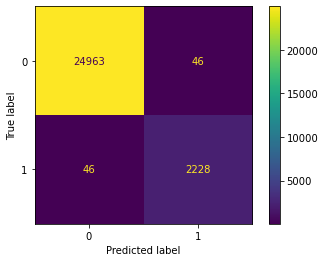

 17%|█▋        | 1/6 [01:42<08:34, 102.92s/it]

LogisticRegression
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     25009
           1       0.85      0.20      0.32      2274

    accuracy                           0.93     27283
   macro avg       0.89      0.60      0.64     27283
weighted avg       0.93      0.93      0.91     27283



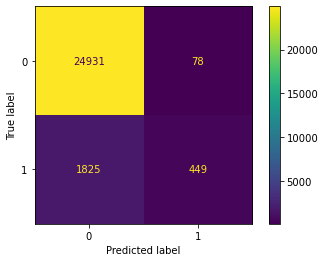

 33%|███▎      | 2/6 [01:45<02:56, 44.08s/it] 

SVC
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     25009
           1       0.99      0.08      0.15      2274

    accuracy                           0.92     27283
   macro avg       0.96      0.54      0.56     27283
weighted avg       0.93      0.92      0.89     27283



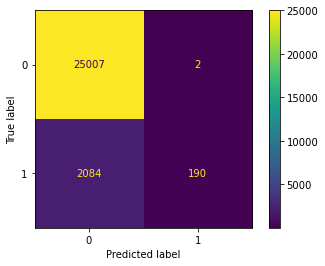

 50%|█████     | 3/6 [09:51<12:17, 245.78s/it]

DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



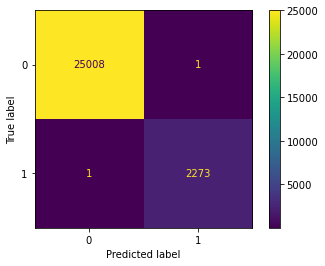

 67%|██████▋   | 4/6 [09:52<04:57, 148.96s/it]

AdaBoostClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



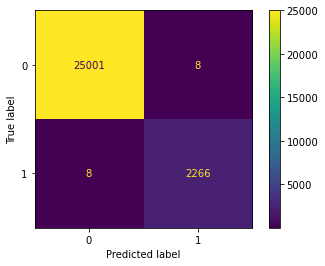

 83%|████████▎ | 5/6 [09:58<01:37, 97.61s/it] 

[14:18:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



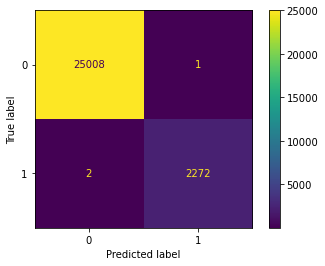

100%|██████████| 6/6 [10:02<00:00, 100.47s/it]


In [115]:
# Confusion matrix and accuracies
rs = 0

knn = KNeighborsClassifier()
log_reg = LogisticRegression(random_state=rs)
svm_classifier = svm.SVC(random_state=rs)
dt = DecisionTreeClassifier(random_state=rs)
ada_boost = AdaBoostClassifier(random_state=rs)
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state=rs)

models = [knn , log_reg , svm_classifier, dt, ada_boost, xgboost]
models_accuracies ={}

for model in tqdm(models):
  model.fit(trX, trY)
  models_accuracies[type(model).__name__] = model.score(teX, teY)
  print(type(model).__name__)

  print(classification_report(teY, model.predict(teX)))

  plot_confusion_matrix(model, teX, teY)
  plt.show()

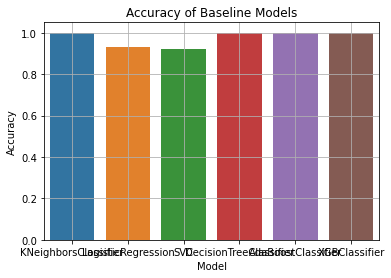

,KNeighborsClassifier,LogisticRegression,SVC,DecisionTreeClassifier,AdaBoostClassifier,XGBClassifier
0,0.996628,0.93025,0.923542,0.999927,0.999414,0.99989


In [116]:
# barplot for baseline models
sns.barplot(x=[type(i).__name__ for i in models], y=[j for i,j in models_accuracies.items() if i in [type(i).__name__ for i in models]])
plt.title('Accuracy of Baseline Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
pd.DataFrame([models_accuracies])

## Bagging & Stacking

In [117]:
# Decision tree cross validation
# xgboost cross validation

estimators = [DecisionTreeClassifier(random_state=rs), xgb.XGBClassifier(objective="binary:logistic", random_state=rs)]
estimators = {estimator.__class__.__name__: estimator for estimator in estimators}

Bagging Weighted F1 Score


  0%|          | 0/2 [00:00<?, ?it/s]

BaggingClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



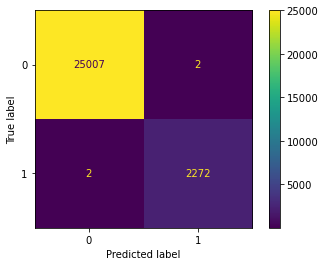

 50%|█████     | 1/2 [00:03<00:03,  3.63s/it]

BaggingClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



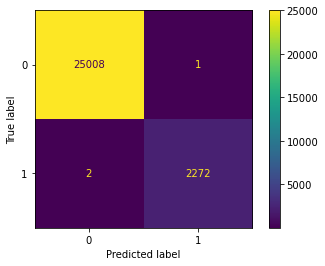

100%|██████████| 2/2 [01:14<00:00, 37.49s/it]


In [118]:
nEst = 20
print(f'Bagging Weighted F1 Score')
for estName, est in tqdm(estimators.items()):
  model = BaggingClassifier(clone(est), n_estimators=nEst, n_jobs=-1)
  model.fit(trX, trY)
  print(type(model).__name__)

  print(classification_report(teY, model.predict(teX)))

  plot_confusion_matrix(model, teX, teY)
  plt.show()

StackingClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25009
           1       1.00      1.00      1.00      2274

    accuracy                           1.00     27283
   macro avg       1.00      1.00      1.00     27283
weighted avg       1.00      1.00      1.00     27283



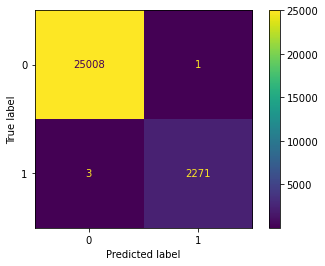

In [119]:
stacking = StackingClassifier([(estName, clone(est)) for estName, est in estimators.items()], DecisionTreeClassifier(random_state=rs), n_jobs=-1)

stacking.fit(trX, trY)
models_accuracies[type(stacking).__name__] = stacking.score(teX, teY)
print(type(stacking).__name__)

print(classification_report(teY, stacking.predict(teX)))

plot_confusion_matrix(stacking, teX, teY)
plt.show()

## Champion Model - xgboost - Cross Validation

In [165]:
X = traindata.loc[:, traindata.columns != 'Label']
y = traindata.loc[:, traindata.columns == 'Label']

In [121]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=rs)
scores = cross_val_score(clf, X, y, cv=5)
scores

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[14:20:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:38] WARNING: /Users/runner/miniforge3/cond

In [122]:
# Cross validation iterator

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=rs)
cross_val_score(clf, X, y, cv=cv)

[14:20:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:58] WARNING: /Users/runner/miniforge3/cond

array([0.99989004, 0.99996335, 0.99996335, 1.        , 1.        ])

# Prediction

In [123]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=rs)
clf.fit(X, y)

[14:21:07] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [124]:
testdata.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,5967,5967,6,38928087,8,2,48.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.541304,0.256884,4.325343e+06,6.594416e+06,15371769.0,0.0,38928087.0,5.561155e+06,7.068528e+06,15371769.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,160,40,0.205507,0.051377,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.600000,6.0,6.0,160,0,0,0,0,0,0,8,48,2,12,5840,0,7,20,64.500000,89.802561,128.0,1.0,1.297599e+07,2.360014e+06,15371769.0,10653446.0,1
1,48161,46578,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,228571.428571,38095.238095,3.500000e+01,5.802586e+01,102.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,2.0,2.0,0.000000e+00,2.0,2.0,0,0,0,0,40,40,19047.619048,19047.619048,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,7.500000,6.0,6.0,40,0,0,0,0,0,0,2,12,2,12,5840,0,1,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1
2,22804,22804,6,24368284,8,6,48.0,36.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.447104,0.574517,1.874483e+06,3.748817e+06,10832964.0,1.0,24368284.0,3.481183e+06,4.645704e+06,10833068.0,1.0,15962113.0,3192422.6,4.814161e+06,10833066.0,1.0,0,0,0,0,160,120,0.328296,0.246222,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.428571,6.0,6.0,160,0,0,0,0,0,0,8,48,6,36,5840,0,7,20,90.000000,25.119713,105.0,61.0,8.122671e+06,2.862532e+06,10832964.0,5128982.0,1
3,48162,43438,6,104,2,2,12.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,230769.230769,38461.538462,3.466667e+01,5.831238e+01,102.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,0.000000e+00,1.0,1.0,0,0,0,0,40,40,19230.769231,19230.769231,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,7.500000,6.0,6.0,40,0,0,0,0,0,0,2,12,2,12,5840,0,1,20,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1
4,61803,61803,6,42848358,8,2,48.0,12.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.400287,0.233381,4.760929e+06,7.153841e+06,14853735.0,1.0,42848245.0,6.121178e+06,7.650009e+06,14853735.0,1.0,2.0,2.0,0.000000e+00,2.0,2.0,0,0,0,0,160,40,0.186705,0.046676,6.0,6.0,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,6.600000,6.0,6.0,160,0,0,0,0,0,0,8,48,2,12,5840,0,7,20,30.333333,25.403412,45.0,1.0,1.428272e+07,8.454236e+05,14853735.0,13311501.0,1


In [125]:
output = pd.DataFrame(clf.predict(testdata), columns=['Class'])
output.index.names = ['ID']
output.head()

,Class
ID,
0,0
1,0
2,0
3,0
4,0


In [126]:
output.to_csv('submission.csv', index=True)

# Hyperparameter Tuning

In [182]:
# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
clf = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X, y), verbose=3, random_state=rs)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[15:31:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:31:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 17 minutes and 24.99 seconds.

 All results:
{'mean_fit_time': array([239.89965701, 226.24106574, 147.13101896, 191.18437274,
       140.34956678]), 'std_fit_time': array([ 2.5951

In [131]:
# clf = xgb.XGBClassifier(
#     objective="binary:logistic",
#     random_state=rs,
#     subsample=1.0,
#     min_child_weight=5,
#     max_depth=4,
#     gamma=2,
#     colsample_bytree=0.8
# )

clf = xgb.XGBClassifier(
    subsample=0.8,
    min_child_weight=5,
    max_depth=5,
    gamma=2,
    colsample_bytree=0.8
)

clf.fit(X, y)

[16:42:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [132]:
output = pd.DataFrame(clf.predict(testdata), columns=['Class'])
output.index.names = ['ID']
output.head()

,Class
ID,
0,0
1,0
2,0
3,0
4,0


In [133]:
output.to_csv('submission.csv', index=True)

# Neural Network

In [166]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(trX.values)
trX_normalized = pd.DataFrame(scaler.transform(trX.values), columns=trX.columns, index=trX.index)
teX_normalized = pd.DataFrame(scaler.transform(teX.values), columns=teX.columns, index=teX.index)
X_normalized = pd.DataFrame(scaler.transform(X.values), columns=X.columns, index=X.index)
testdata_normalized = pd.DataFrame(scaler.transform(testdata.values), columns=testdata.columns, index=testdata.index)

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# model = keras.Sequential([
#     layers.Dense(512, activation="relu"),
#     layers.Dense(2, activation="softmax")
# ])
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(81,)),
    tf.keras.layers.Dense(67, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(15, activation='softmax')
])

model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.fit(trX_normalized, trY, epochs=25, batch_size=128)

yhat = model.predict(teX_normalized)

test_loss, test_acc = model.evaluate(teX_normalized, teY)
print(f"test_acc: {test_acc}")

Epoch 1/25
853/853 [==============================] - 4s 5ms/step - loss: 0.1634 - accuracy: 0.9558
Epoch 2/25
853/853 [==============================] - 4s 5ms/step - loss: 0.0198 - accuracy: 0.9918
Epoch 3/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0097 - accuracy: 0.9983
Epoch 4/25
853/853 [==============================] - 4s 5ms/step - loss: 0.0056 - accuracy: 0.9992
Epoch 5/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0040 - accuracy: 0.9994
Epoch 6/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0029 - accuracy: 0.9996
Epoch 7/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0023 - accuracy: 0.9997
Epoch 8/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0019 - accuracy: 0.9997
Epoch 9/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 10/25
853/853 [==============================] - 4s 4ms/step - loss: 0.0013 - accuracy: 0.9998

In [177]:
model.fit(X_normalized, y, epochs=25, batch_size=128)

yhat = model.predict(testdata_normalized)

Epoch 1/25
1066/1066 [==============================] - 5s 4ms/step - loss: 8.6616e-04 - accuracy: 0.9998
Epoch 2/25
1066/1066 [==============================] - 5s 4ms/step - loss: 7.0670e-04 - accuracy: 0.9998
Epoch 3/25
1066/1066 [==============================] - 5s 4ms/step - loss: 6.1534e-04 - accuracy: 0.9998
Epoch 4/25
1066/1066 [==============================] - 5s 4ms/step - loss: 6.8181e-04 - accuracy: 0.9998
Epoch 5/25
1066/1066 [==============================] - 5s 4ms/step - loss: 7.2073e-04 - accuracy: 0.9999
Epoch 6/25
1066/1066 [==============================] - 5s 4ms/step - loss: 5.1104e-04 - accuracy: 0.9999
Epoch 7/25
1066/1066 [==============================] - 5s 4ms/step - loss: 6.4211e-04 - accuracy: 0.9998
Epoch 8/25
1066/1066 [==============================] - 5s 4ms/step - loss: 6.0924e-04 - accuracy: 0.9999
Epoch 9/25
1066/1066 [==============================] - 5s 4ms/step - loss: 5.3422e-04 - accuracy: 0.9999
Epoch 10/25
1066/1066 [=======================

In [178]:
output_class = [[0, 1][probabilities.argmax()] for probabilities in yhat]

In [179]:
output = pd.DataFrame(output_class, columns=['Class'])
output.index.names = ['ID']
output.head()

,Class
ID,
0,0
1,0
2,0
3,0
4,0


In [180]:
output.to_csv('submission.csv', index=True)